### Exploring Ensemble Methods

In this homework we will explore the use of boosting. For this assignment, we will use the pre-implemented gradient boosted trees in Graphlab-Create. You will:

Use SFrames to do some feature engineering.

Train a boosted ensemble of decision-trees (gradient boosted trees) on the lending club dataset.

Predict whether a loan will default along with prediction probabilities (on a validation set).

Evaluate the trained model and compare it with a baseline.

Find the most positive and negative loans using the learned model.

Explore how the number of trees influences classification performance.

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style()

In [20]:
loans = pd.read_csv('lending-club-data.csv')

f:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Modifying the target column

The target column (label column) of the dataset that we are interested in is called bad_loans. In this column 1 means a risky (bad) loan 0 means a safe loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:

+1 as a safe loan

-1 as a risky (bad) loan

We put this in a new column called safe_loans.

In [21]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x: 1 if x == 0 else -1)

In [22]:
loans.drop('bad_loans', axis=1, inplace=True)

In [23]:
'bad_loans' in loans.columns

False

### The features we will be using are described in the code comments below. Extract these feature columns and target column from the dataset. We will only use these features.

In [24]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

### Skipping observations with missing values

Recall from the lectures that one common approach to coping with missing values is to skip observations that contain missing values.

In [25]:
loans = loans[[target] + features]

In [26]:
len(loans)

122607

In [27]:
loans.dropna(inplace=True)

In [28]:
len(loans)

122578

In [29]:
loans.columns

Index(['safe_loans', 'grade', 'sub_grade_num', 'short_emp', 'emp_length_num',
       'home_ownership', 'dti', 'purpose', 'payment_inc_ratio', 'delinq_2yrs',
       'delinq_2yrs_zero', 'inq_last_6mths', 'last_delinq_none',
       'last_major_derog_none', 'open_acc', 'pub_rec', 'pub_rec_zero',
       'revol_util', 'total_rec_late_fee', 'int_rate', 'total_rec_int',
       'annual_inc', 'funded_amnt', 'funded_amnt_inv', 'installment'],
      dtype='object')

### Apply one-hot encoding to loans.
For scikit-learn's decision tree implementation, it numerical values for it's data matrix. This means you will have to turn categorical variables into binary features via one-hot encoding.

Note that the column names are slightly different now, since we used one-hot encoding.

In [30]:
loans.head()

,safe_loans,grade,sub_grade_num,short_emp,emp_length_num,home_ownership,dti,purpose,payment_inc_ratio,delinq_2yrs,...,pub_rec,pub_rec_zero,revol_util,total_rec_late_fee,int_rate,total_rec_int,annual_inc,funded_amnt,funded_amnt_inv,installment
0,1,B,0.4,0,11,RENT,27.65,credit_card,8.14350,0.0,...,0.0,1.0,83.7,0.00,10.65,861.07,24000.0,5000,4975,162.87
1,-1,C,0.8,1,1,RENT,1.00,car,2.39320,0.0,...,0.0,1.0,9.4,0.00,15.27,435.17,30000.0,2500,2500,59.83
2,1,C,1.0,0,11,RENT,8.72,small_business,8.25955,0.0,...,0.0,1.0,98.5,0.00,15.96,603.65,12252.0,2400,2400,84.33
3,1,C,0.2,0,11,RENT,20.00,other,8.27585,0.0,...,0.0,1.0,21.0,16.97,13.49,2209.33,49200.0,10000,10000,339.31
4,1,A,0.8,0,4,RENT,11.20,wedding,5.21533,0.0,...,0.0,1.0,28.3,0.00,7.90,631.38,36000.0,5000,5000,156.46


In [31]:
test = pd.get_dummies(loans)

In [35]:
test.head()[['grade_A', 'grade_B']]

,grade_A,grade_B
0,0,1
1,0,0
2,0,0
3,0,0
4,1,0


In [36]:
loans = pd.get_dummies(loans)

In [37]:
train_idx = pd.read_json('module-8-assignment-1-train-idx.json')
validation_idx = pd.read_json('module-8-assignment-1-validation-idx.json')

In [42]:
train_data = loans.iloc[train_idx[0]]

In [43]:
validation_data = loans.iloc[validation_idx[0]]

In [44]:
train_data.head()

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
1,-1,0.8,1,1,1.00,2.39320,0.0,1.0,5.0,1,...,0,0,0,0,0,0,0,0,0,0
6,-1,0.4,0,5,5.55,4.57170,0.0,1.0,2.0,1,...,0,0,0,0,0,0,0,1,0,0
7,-1,1.0,1,1,18.08,9.71600,0.0,1.0,0.0,1,...,0,0,0,0,0,0,1,0,0,0
10,-1,0.2,1,1,10.08,12.21520,0.0,1.0,1.0,1,...,1,0,0,0,0,0,0,0,0,0
12,-1,0.4,0,4,7.06,3.90888,0.0,1.0,2.0,1,...,0,0,0,0,0,0,1,0,0,0


### Gradient boosted tree classifier

Gradient boosted trees are a powerful variant of boosting methods; they have been used to win many Kaggle competitions, and have been widely used in industry. We will explore the predictive power of multiple decision trees as opposed to a single decision tree.

Additional reading: If you are interested in gradient boosted trees, here is some additional reading material:

We will now train models to predict safe_loans using the features above. In this section, we will experiment with training an ensemble of 5 trees.

Now, let's use the built-in scikit learn gradient boosting classifier (sklearn.ensemble.GradientBoostingClassifier) to create a gradient boosted classifier on the training data. You will need to import sklearn, sklearn.ensemble, and numpy.

Official Documents:

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

Parameter Tuning:

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

You will have to first convert the SFrame into a numpy data matrix. See the API for more information. You will also have to extract the label column. Make sure to set max_depth=6 and n_estimators=5.

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

f:\anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [40]:
model_5 = GradientBoostingClassifier(max_depth=6, n_estimators=5)

### Making predictions

Just like we did in previous sections, let us consider a few positive and negative examples from the validation set. We will do the following:

Predict whether or not a loan is likely to default.

Predict the probability with which the loan is likely to default.

### First, let's grab 2 positive examples and 2 negative examples. 

In [45]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
22,1,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
26,1,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
24,-1,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
41,-1,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0


#### For each row in the sample_validation_data, write code to make model_5 predict whether or not the loan is classified as a safe loan.

In [48]:
feature_list = validation_data.columns.tolist()[1: ]

In [51]:
model_5.fit(train_data[feature_list], train_data[target])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [52]:
model_5.predict(sample_validation_data[feature_list])

array([ 1,  1, -1,  1], dtype=int64)

In [54]:
model_5.score(sample_validation_data[feature_list], sample_validation_data[target])

0.75

### Prediction Probabilities
#### For each row in the sample_validation_data, what is the probability (according model_5) of a loan being classified as safe? (Hint: if you are using scikit-learn, you can use the .predict_proba() method)

In [96]:
model_5.predict_proba(sample_validation_data[feature_list])#[:, 1]

array([[0.41642331, 0.58357669],
       [0.46949689, 0.53050311],
       [0.53807792, 0.46192208],
       [0.39591639, 0.60408361]])

### Evaluating the model on the validation data

#### Evaluate the accuracy of the model_5 on the validation_data. (Hint: if you are using scikit-learn, you can use the .score() method)
Calculate the number of false positives made by the model on the validation_data.

accuracy = # correctly classified data points / # total data points

In [61]:
model_5.score(validation_data[feature_list], validation_data[target])

0.6613528651443343

In [63]:
np.sum(model_5.predict(validation_data[feature_list]) == validation_data[target]) / len(validation_data)

0.6613528651443343

#### Calculate the number of false negatives made by the model on the validation_data.
##### https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative
##### https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal

In [64]:
predict_result = model_5.predict(validation_data[feature_list])

In [69]:
FN = 0
FP = 0
for i in range(len(predict_result)):
    if predict_result[i] == -1 and validation_data[target].iloc[i] == 1:
        FN += 1
    if predict_result[i] == 1 and validation_data[target].iloc[i] == -1:
        FP += 1
print("False Negative is {}".format(FN))
print("False Positive is {}".format(FP))

False Negative is 1491
False Positive is 1653


### Comparison with decision trees 
In the earlier assignment, we saw that the prediction accuracy of the decision trees was around 0.64. In this assignment, we saw that model_5 has an accuracy of approximately 0.67.

Here, we quantify the benefit of the extra 3% increase in accuracy of model_5 in comparison with a single decision tree from the original decision tree assignment.

As we explored in the earlier assignment, we calculated the cost of the mistakes made by the model. We again consider the same costs as follows:

False negatives: Assume a cost of $10,000 per false negative.
False positives: Assume a cost of $20,000 per false positive.
Assume that the number of false positives and false negatives for the learned decision tree was

False negatives: 1936
False positives: 1503
Using the costs defined above and the number of false positives and false negatives for the decision tree, we can calculate the total cost of the mistakes made by the decision tree model as follows:

cost = $10,000 * 1936  + $20,000 * 1503 = $49,420,000

Calculate the cost of mistakes made by model_5 on the validation_data.

In [72]:
(1e4 * 1491 + 2e4 * 1653)# < 49320000

47970000.0

#### Most positive & negative loans.
In this section, we will find the loans that are most likely to be predicted safe. We can do this in a few steps:

1. Use the model_5 (the model with 5 trees) and make probability predictions for all the loans in validation_data.
2. Similar to what we did in the very first assignment, add the probability predictions as a column called predictions into validation_data.
3. Sort the data (in descreasing order) by the probability predictions.

Start here with Step 1 & Step 2. Make predictions using model_5 for all examples in the validation_data.

Checkpoint: For each row, the probabilities should be a number in the range [0, 1].

Now, we are ready to go to Step 3. You can now use the prediction column to sort the loans in validation_data (in descending order) by prediction probability. Find the top 5 loans with the highest probability of being predicted as a safe loan.

In [77]:
# set the probability of +1 as the value of predictions
validation_data['predictions'] = model_5.predict_proba(validation_data[feature_list])[:, 1]

f:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [84]:
validation_data[['grade_A', 'grade_B', 'grade_C', 'grade_D', 'predictions']].sort_values(['predictions'], 
                                                                                         ascending=False).head()

,grade_A,grade_B,grade_C,grade_D,predictions
8021,1,0,0,0,0.673059
15960,1,0,0,0,0.661468
5516,1,0,0,0,0.661468
47586,1,0,0,0,0.661468
22958,1,0,0,0,0.661468


In [97]:
mylist = ['grade_A', 'grade_B', 'grade_C', 'grade_D', 'predictions']
validation_data[validation_data[mylist].sort_values(['predictions'], 
                                                    ascending=True)['predictions'] > 0.5].tail()[mylist]

f:\anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,grade_A,grade_B,grade_C,grade_D,predictions
122269,0,0,1,0,0.526161
122307,0,0,1,0,0.522023
122354,0,1,0,0,0.526925
122421,0,0,1,0,0.523047
122436,1,0,0,0,0.579741


#### Effects of adding more trees
In this assignment, we will train 5 different ensemble classifiers in the form of gradient boosted trees.

Train models with 10, 50, 100, 200, and 500 trees. Use the n_estimators parameter to control the number of trees. Remember to keep max_depth = 6.

Call these models model_10, model_50, model_100, model_200, and model_500, respectively. This may take a few minutes to run.

Compare accuracy on entire validation set

Now we will compare the predicitve accuracy of our models on the validation set.

Evaluate the accuracy of the 10, 50, 100, 200, and 500 tree models on the validation_data.

Quiz Question: Which model has the best accuracy on the validation_data?

In [98]:
model_10 = GradientBoostingClassifier(max_depth=6, n_estimators=10)
model_10.fit(train_data[feature_list], train_data[target])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [99]:
model_50 = GradientBoostingClassifier(max_depth=6, n_estimators=50)
model_50.fit(train_data[feature_list], train_data[target])

model_100 = GradientBoostingClassifier(max_depth=6, n_estimators=100)
model_100.fit(train_data[feature_list], train_data[target])

model_200 = GradientBoostingClassifier(max_depth=6, n_estimators=200)
model_200.fit(train_data[feature_list], train_data[target])

model_500 = GradientBoostingClassifier(max_depth=6, n_estimators=500)
model_500.fit(train_data[feature_list], train_data[target])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [100]:
print('Model 10 Accuracy is {}'.format(model_10.score(validation_data[feature_list], validation_data[target])))
print('Model 50 Accuracy is {}'.format(model_50.score(validation_data[feature_list], validation_data[target])))
print('Model 100 Accuracy is {}'.format(model_100.score(validation_data[feature_list], validation_data[target])))
print('Model 200 Accuracy is {}'.format(model_200.score(validation_data[feature_list], validation_data[target])))
print('Model 500 Accuracy is {}'.format(model_500.score(validation_data[feature_list], validation_data[target])))

Model 10 Accuracy is 0.6664153382162861
Model 50 Accuracy is 0.683649289099526
Model 100 Accuracy is 0.6896811719086601
Model 200 Accuracy is 0.6864498061180526
Model 500 Accuracy is 0.6865575183110728


### Plot the training and validation error vs. number of trees

Recall from the lecture that the classification error is defined as

[classification error] = 1−[accuracy]

In this section, we will plot the training and validation errors versus the number of trees to get a sense of how these models are performing. We will compare the 10, 50, 100, 200, and 500 tree models. You will need matplotlib in order to visualize the plots.

Steps to follow:

1. Calculate the classification error for each model on the training data (train_data).
2. Store the training errors into a list (called training_errors) that looks like this: [train_err_10, train_err_50, ..., train_err_500]
3. Calculate the classification error of each model on the validation data (validation_data).
4. Store the validation classification error into a list (called validation_errors) that looks like this:[validation_err_10, validation_err_50, ..., validation_err_500]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
validation_errors = [
    1 - model_10.score(validation_data[feature_list], validation_data[target]),
    1 - model_50.score(validation_data[feature_list], validation_data[target]),
    1 - model_100.score(validation_data[feature_list], validation_data[target]),
    1 - model_200.score(validation_data[feature_list], validation_data[target]),
    1 - model_500.score(validation_data[feature_list], validation_data[target])
]
training_errors = [
    1 - model_10.score(train_data[feature_list], train_data[target]),
    1 - model_50.score(train_data[feature_list], train_data[target]),
    1 - model_100.score(train_data[feature_list], train_data[target]),
    1 - model_200.score(train_data[feature_list], train_data[target]),
    1 - model_500.score(train_data[feature_list], train_data[target])
]

In [102]:
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

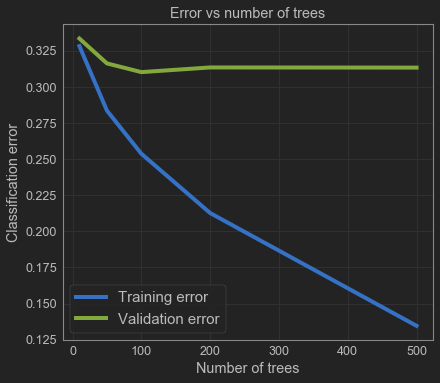

In [106]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')